In [1]:
import re
import os
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from Bio import AlignIO

In [3]:
hmm_path = '/nethome/kgeorge/workspace/DomainPrediction/hmm'
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data'

In [4]:
tm_path = './nethome/kgeorge/workspace/DomainPrediction/src/utils/TMalign'
class TMalign():
    def __init__(self, path) -> None:
        self.tmalign = path

    def run(self, prot_a, prot_b):
        out = subprocess.check_output([self.tmalign, prot_a, prot_b])
        data = str(out).split("\\n")
        for d in data:
            x = re.sub(r"\s\s+", " ", d).split(' ')
            if x[0] == 'Aligned':
                rmsd = float(x[4][:-1])
                seq_id = float(x[6])
            elif x[0] == 'TM-score=':
                tm_score = float(x[1])
                break

        return {
            'rmsd': rmsd,
            'seq_id': seq_id,
            'tm_score': tm_score
        }

In [5]:
class HmmerTools():
    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def hmmalign(self, hmm_path: str, fasta_file: str, 
                  outfile: str | None = None, 
                  trim: bool = False):
        if outfile is None:
            outfile = fasta_file.replace('.fasta', '.stockholm')

        if trim:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', '--trim', hmm_path, fasta_file], stdout=fout)
        else:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', hmm_path, fasta_file], stdout=fout)

        print(f'alignment created: {outfile}')


    def parse_hmmsearch_tblout(self, filename):
        with open(filename) as fin:
            tmp = []
            for line in fin:
                if not line.startswith('#'):
                    tmp.append(line.strip().split()[:7])

        df = pd.DataFrame(tmp, columns=['name', '-', 'domain', 'domain_id', 'Evalue', 'score', 'bias'])
        df['Evalue'] = df['Evalue'].astype(float)
        df['score'] = df['score'].astype(float)
        df['bias'] = df['bias'].astype(float)

        return df

    def sort_by_Eval(self, df, top=None):
        df_tmp = df[['name']].drop_duplicates().sort_values(by=['name']).reset_index(drop=True)
        
        for domain in df['domain'].unique():
            print(f'domain {domain} {df[df["domain"] == domain].shape[0]}')
            df_tmp[domain] = df[df['domain'] == domain].sort_values(by=['name'])['Evalue'].to_numpy()

        df_tmp['sum'] = df_tmp[df['domain'].unique()].sum(axis=1)

        df_tmp['norm_sum'] = self.scaler.fit_transform(df_tmp[df['domain'].unique()]).sum(axis=1)

        df_sorted = df_tmp.sort_values(by=['norm_sum'])
        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]
        
    def sort_by_Eval_domain(self, df, domain, top=None):

        df_tmp = df[df['domain'] == domain]
        df_sorted = df_tmp.sort_values(by=['Evalue'])

        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]

In [36]:
class AlignTools():
    def __init__(self, path: str) -> None:
        self.align = AlignIO.read(path, "stockholm")
    
    def show_alignment(self):
        print(self.align)

    def get_alignment_length(self):
        return self.align.get_alignment_length()
    
    def get_num_sequences(self):
        return len(self.align)

    def get_pairwise_identity(self):
        pairwise_seqid = np.eye(self.get_num_sequences())

        for i, record_1 in enumerate(self.align):
            for j, record_2 in enumerate(self.align):
                seq_id = 0
                for s1, s2 in zip(record_1.seq, record_2.seq):
                    if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                        seq_id += 1

                pairwise_seqid[i,j] = seq_id/self.get_alignment_length()

        return pairwise_seqid
    
    def get_pairwise_identity_(self):
        pairwise_seqid = []

        base_rec = self.align[0]
        for i, record_1 in enumerate(self.align[1:]):
            seq_id = 0
            for s1, s2 in zip(record_1.seq, base_rec.seq):
                if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                    seq_id += 1

            pairwise_seqid.append(seq_id/self.get_alignment_length())

        return np.array(pairwise_seqid)

In [7]:
tmalign = TMalign(tm_path)
hmmer = HmmerTools()

In [8]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=True)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/esm_inp_seq_1000.stockholm


In [37]:
align_esm_seq = AlignTools(os.path.join(data_path, 'esm_experiments/gen_1000/esm_inp_seq_1000.stockholm'))

In [38]:
align_esm_seq.get_num_sequences()

2001

In [39]:
align_esm_seq.get_pairwise_identity_()

array([0.38157895, 0.42105263, 0.39473684, ..., 0.38157895, 0.43421053,
       0.35526316])

In [18]:
# # wrt to original. original at 0 
# align_esm_seq.get_pairwise_identity()[0][1:]

In [19]:
# # all pairwise except original
# align_esm_seq.get_pairwise_identity()[1:,1:][np.triu_indices(5, k = 1)]

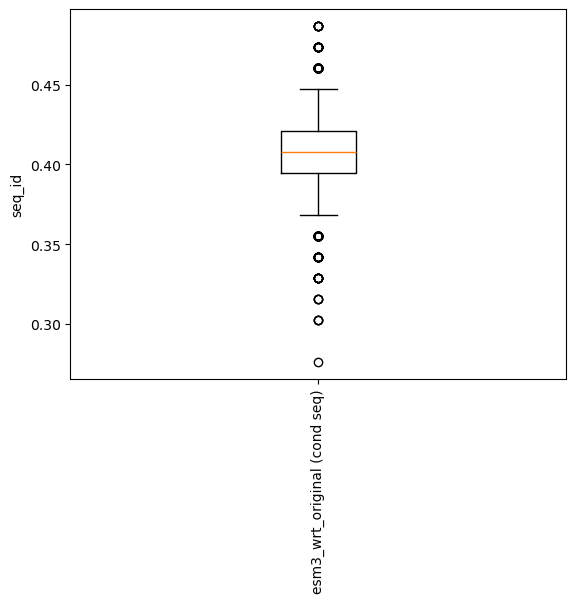

In [40]:
fig, ax = plt.subplots()
_ = ax.boxplot([align_esm_seq.get_pairwise_identity_()],
               labels=['esm3_wrt_original (cond seq)'])
ax.set_ylabel('seq_id')
ax.tick_params(axis='x', labelrotation=90)

In [41]:
align_esm_seq.show_alignment()

Alignment with 2001 rows and 76 columns
--LATIWRELLN-V-EQ-------VGRHDSFFALGGHSLLAVRM...Q-- GxpS_ATC
QALSEIWAELLG-L-E--R-----VGIHDNFFELGGHSILAIQA...ERL GxpS_ATC-temp_0.5-gen_0
QALAGIWAEVLG-L-E--R-----VGIHDNFFELGGHSILAIQV...QRI GxpS_ATC-temp_0.5-gen_1
-LLAEIWGEVLG-L-D--R-----IGLHDNFFDLGGHSILAIQV...SRI GxpS_ATC-temp_0.5-gen_2
ERLAGIWADVLG-L-E--R-----VGIHDNFFDLGGHSLLAIRV...AQ- GxpS_ATC-temp_0.5-gen_3
-VLAAIWAEMLG-L-E--R-----VGVHDNFFELGGHSILSIQL...GLI GxpS_ATC-temp_0.5-gen_4
--LAGIWQDVLG-L-S--R-----IGRHDNFFELGGHSILAIQV...ERI GxpS_ATC-temp_0.5-gen_5
-ALAAIWQEVLG-V-E--R-----IGIHDNFFELGGHSILAIQV...--- GxpS_ATC-temp_0.5-gen_6
-VLAEIWREVLG-L-E--R-----IGVHDNFFELGGDSILAIQV...ARI GxpS_ATC-temp_0.5-gen_7
-VLAAIWAELLG-I-E--R-----VGVHDNFFELGGHSILAVQL...ARI GxpS_ATC-temp_0.5-gen_8
QQLADIWAELLG-L-E--R-----VGVHDNFFELGGHSILAIRL...AHI GxpS_ATC-temp_0.5-gen_9
-TLAELWAELLG-V-E--R-----IGRHDNFFELGGDSILAIRI...SAI GxpS_ATC-temp_0.5-gen_10
QALASIWAEVLG-V-E--R-----VGVHDNFFELGGHSILAIQV...ARL GxpS_ATC-temp_0.5-gen_1

In [22]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [56]:
esm_fasta = SeqIO.parse('/nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/esm_inp_seq_1000.fasta', 'fasta')
seq_id = align_esm_seq.get_pairwise_identity_()

In [57]:
combined_records = []
T = [i for i in range(538,608)] ## 539-608
for i, rec in enumerate(esm_fasta):
    if rec.id != "GxpS_ATC":
        # seq_rec = SeqRecord(Seq(''.join([str(rec.seq)[i] for i in T])), id=rec.id, name=rec.name, description=rec.description)
        seq_rec = rec
        combined_records.append((seq_rec, seq_id[i-1]))

In [58]:
rec

SeqRecord(seq=Seq('MSTRISEVTLLPEAERRQILVDWNDTAASYPRDVCVHQLFEQQIEKTPDAIAVI...PRP'), id='GxpS_ATC-temp_0.5-gen_1999', name='GxpS_ATC-temp_0.5-gen_1999', description='GxpS_ATC-temp_0.5-gen_1999', dbxrefs=[])

In [59]:
sorted_list = sorted(combined_records, key=lambda k: k[1], reverse=True)

In [62]:
with open('/nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/esm_top_30.fasta', 'w') as file:
    SeqIO.write([rec[0] for rec in sorted_list[:30]], file, "fasta")